# Module 7: Databases!

## Topic 1: Quick Overview of Databases

### This topic includes a review link for database creation and table creation.  It also has a link to DB Browser which you should download and install

## Topic 2: SQLite/DB Browser and Database Creation

### In this topic, we're going to create a database and some linked tables

### First, a function to create a connection and database (if it doesn't already exist)

In [47]:
import sqlite3
from sqlite3 import Error

# This function creates a database connection and database if it doesn't already exist
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)

    return conn

### Now a function to create a table in the database

In [48]:
def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

### We can now use our functions to create some tables

In [49]:
database = "unemployment_by_county.db"
sql_create_unemployment_table = """ CREATE TABLE IF NOT EXISTS Unemployment (
                                        year integer NOT NULL,
                                        unemployment_rate real,
                                        county text,
                                        FOREIGN KEY (county) 
                                            REFERENCES County_data (county)
                                    ); """

sql_create_county_data_table = """CREATE TABLE IF NOT EXISTS County_data (
                                    county text PRIMARY KEY,
                                    mhi real NOT NULL
                                );"""

# create a database connection and database if it doesn't already exist
conn = create_connection(database)

# create tables
if conn is not None:
    # create County_data table
    create_table(conn, sql_create_county_data_table)

    # create Unemployment table
    create_table(conn, sql_create_unemployment_table)
else:
    print("Error! cannot create the database connection.")

### With our tables created, we can pull in some info to have a look at it

In [50]:
cur = conn.cursor()
meta = cur.execute("PRAGMA table_info('Unemployment')")
for r in meta:
    print(r)

(0, 'year', 'integer', 1, None, 0)
(1, 'unemployment_rate', 'real', 0, None, 0)
(2, 'county', 'text', 0, None, 0)


### This code will give us a list of the tables and columns

In [51]:
# Code pulled/modified from https://stackoverflow.com/questions/305378/list-of-tables-db-schema-dump-etc-using-the-python-sqlite3-api
# Using with command to automatically close the connection

with sqlite3.connect('unemployment_by_county.db') as db:
    newline_indent = '\n   '
   
    cur = db.cursor()

    result = cur.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    table_names = sorted(list(zip(*result))[0])
    print ("\ntables are:"+newline_indent+newline_indent.join(table_names))

    for table_name in table_names:
        result = cur.execute("PRAGMA table_info('%s')" % table_name).fetchall()
        column_names = list(zip(*result))[1]
        print (("\ncolumn names for %s:" % table_name)
               +newline_indent
               +(newline_indent.join(column_names)))


tables are:
   County_data
   Unemployment

column names for County_data:
   county
   mhi

column names for Unemployment:
   year
   unemployment_rate
   county


### We could also utilize DB Browser to get a GUI view of the database.  I suggest this because it's much easier to see your database structure this way.

## Topic 3: CRUD (Create/Read)

### Since we've got our tables created, we should probably put some data in.  Let's grab some data and bring it into our tables

In [53]:
import csv
database = 'unemployment_by_county.db'
conn = create_connection(database)
cur = conn.cursor()

with open('Median_house_income_by_county.csv','r') as input_file:
    data = csv.DictReader(input_file)
    to_db = [(i['county'],i['Median Household Income']) for i in data]
    
    to_db_cty = [item[0] for item in to_db]
    for x in range(0,len(to_db)):
        to_db_cty[x]=tuple([to_db_cty[x],to_db[x][1]])
#print(to_db_cty)
        
with open('Unemployment_by_county.csv','r') as input_file:
    data = csv.DictReader(input_file)
    to_db = [(i['year'],i['unemployment rate'],i['county']) for i in data]
    
    #to_db_unemployment = [item[2] for item in to_db]
    to_db_data_insert = [[] for item in to_db]
    for x in range(0,len(to_db)):
        to_db_data_insert[x] = tuple([to_db[x][0],to_db[x][1],to_db[x][2]])
        
#print (to_db)
#print (to_db_data_insert)

cur.executemany("REPLACE INTO County_data (county,mhi) VALUES (?, ?);", to_db_cty)
cur.executemany("REPLACE INTO Unemployment (year, unemployment_rate, county) VALUES (?,?,?)",to_db_data_insert)
conn.commit()
conn.close()

### We now have our data loaded into the database.  Let's bring it into our program into a dataframe so we can work with it

In [12]:
import pandas as pd
unemployment_df = pd.read_sql_query("SELECT * FROM Unemployment",sqlite3.connect('unemployment_by_county.db'))

In [13]:
print(unemployment_df.head(5))

   year  unemployment_rate county
0  2011                5.7   Polk
1  2012                5.2   Polk
2  2013                4.8   Polk
3  2014                4.2   Polk
4  2015                3.7   Polk


### BTW, if you accidentally added too much or repetitive data into your table, here's how to delete it all quickly

In [52]:
database = 'unemployment_by_county.db'
conn = create_connection(database)
cur = conn.cursor()

cur.execute("DELETE FROM Unemployment")

conn.commit()
conn.close()

### Let's create a visual now that our data is in a dataframe

In [15]:
import matplotlib.pyplot as plt

data_polk = unemployment_df[unemployment_df['county'] == "Polk"]
data_polk.sort_values('year',inplace=True)
plot_y_polk = list(data_polk['unemployment_rate'])

data_dallas = unemployment_df[unemployment_df['county'] == "Dallas"]
data_dallas.sort_values('year',inplace=True)
plot_y_dallas = list(data_dallas['unemployment_rate'])

data_scott = unemployment_df[unemployment_df['county'] == "Scott"]
data_scott.sort_values('year',inplace=True)
plot_y_scott = list(data_scott['unemployment_rate'])

plot_x = list(data_polk['year'])
print(plot_x)

[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


C:\Users\magilbertson\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\magilbertson\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\magilbertson\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


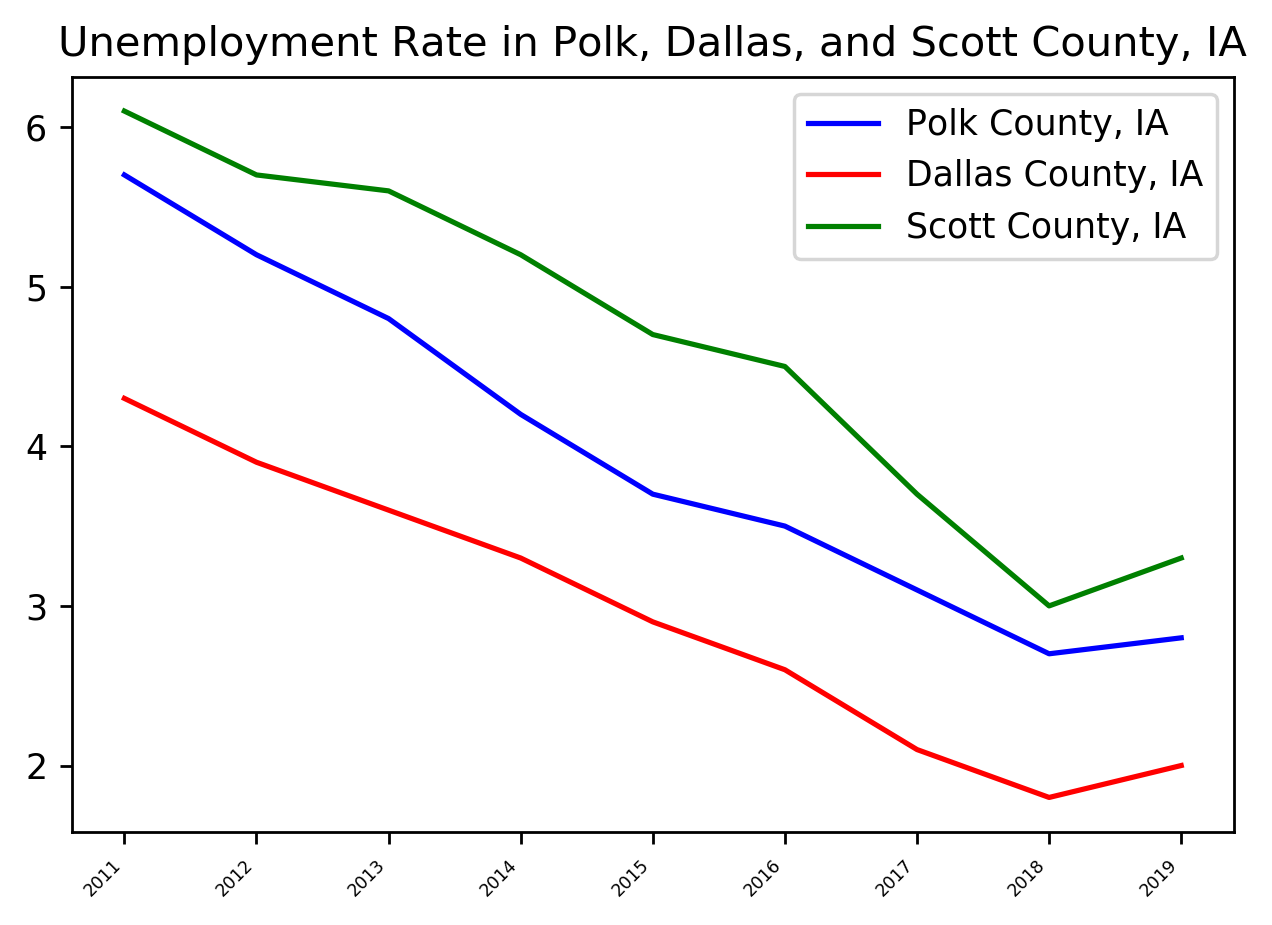

In [18]:
ax = plt.subplot(111)
plt.rcParams['figure.dpi'] = 250

ax.plot(plot_x, plot_y_polk, color='b',label="Polk County, IA")
ax.plot(plot_x, plot_y_dallas, color='r',label = "Dallas County, IA")
ax.plot(plot_x, plot_y_scott, color='g',label = "Scott County, IA")

ax.axes.set_xticks(plot_x)
ax.axes.set_xticklabels(plot_x,rotation = 45,ha ='right',Fontsize=5)
ax.legend()
ax.title.set_text('Unemployment Rate in Polk, Dallas, and Scott County, IA')


## Topic 4: Update/Delete Operations

### For the assignment on this topic, you're asked to create a database copy before making updates because you need to submit the database before making your changes.  
### While there are ways to do this in Python (and you are welcome to do this if you want), it's easier to make your copy from a directory view on your computer 

### First, we want to read in the county median income data and convert them to monthly

In [24]:
database = 'unemployment_by_county.db'
conn = create_connection(database)
cur = conn.cursor()

with sqlite3.connect('unemployment_by_county.db') as db:
    income_in_years = conn.execute('SELECT mhi,county FROM County_data').fetchall()
print(income_in_years)
conn.close()

[(68479.0, 'Polk'), (59865.0, 'Scott'), (87267.0, 'Dallas')]


### You can see that I get a list of tuples this way, which is the how data comes from SQLite normally.  Now to convert to months and prepare to insert back into the database

In [26]:
income_in_months = []
for incrementer in range(0,3):
    income_in_months.append((round(income_in_years[incrementer][0]/12,2),income_in_years[incrementer][1]))
print(income_in_months)

[(5706.58, 'Polk'), (4988.75, 'Scott'), (7272.25, 'Dallas')]


### Let's put it back into the database column

In [27]:
database = 'unemployment_by_county.db'
conn = create_connection(database)
cur = conn.cursor()

with sqlite3.connect(database) as db: 

    conn.executemany('UPDATE County_data SET mhi=? WHERE county=?',income_in_months)
conn.commit()
conn.close()

### Now I've realized that I need to change my year by 1 because I was off by 1 year.  We need to decrement by 1 year

### I'll first bring the current year column in from the database


In [42]:
database = 'unemployment_by_county.db'
conn = create_connection(database)
cur = conn.cursor()

with sqlite3.connect('unemployment_by_county.db') as db:
    old_year = conn.execute('SELECT year,county FROM Unemployment').fetchall()
print(old_year)

[(2011, 'Polk'), (2012, 'Polk'), (2013, 'Polk'), (2014, 'Polk'), (2015, 'Polk'), (2016, 'Polk'), (2017, 'Polk'), (2018, 'Polk'), (2019, 'Polk'), (2011, 'Scott'), (2012, 'Scott'), (2013, 'Scott'), (2014, 'Scott'), (2015, 'Scott'), (2016, 'Scott'), (2017, 'Scott'), (2018, 'Scott'), (2019, 'Scott'), (2011, 'Dallas'), (2012, 'Dallas'), (2013, 'Dallas'), (2014, 'Dallas'), (2015, 'Dallas'), (2016, 'Dallas'), (2017, 'Dallas'), (2018, 'Dallas'), (2019, 'Dallas')]


### I'm now going to make a list of tuples that have the new date and the old date next to it
### This step is to confirm that I have my date shifting correct

In [44]:
new_year_old_year = []
for incrementer in range(0,27):
    new_year_old_year.append((int(old_year[incrementer][0]) - 1,old_year[incrementer][0],old_year[incrementer][1]))
print(new_year_old_year)

[(2010, 2011, 'Polk'), (2011, 2012, 'Polk'), (2012, 2013, 'Polk'), (2013, 2014, 'Polk'), (2014, 2015, 'Polk'), (2015, 2016, 'Polk'), (2016, 2017, 'Polk'), (2017, 2018, 'Polk'), (2018, 2019, 'Polk'), (2010, 2011, 'Scott'), (2011, 2012, 'Scott'), (2012, 2013, 'Scott'), (2013, 2014, 'Scott'), (2014, 2015, 'Scott'), (2015, 2016, 'Scott'), (2016, 2017, 'Scott'), (2017, 2018, 'Scott'), (2018, 2019, 'Scott'), (2010, 2011, 'Dallas'), (2011, 2012, 'Dallas'), (2012, 2013, 'Dallas'), (2013, 2014, 'Dallas'), (2014, 2015, 'Dallas'), (2015, 2016, 'Dallas'), (2016, 2017, 'Dallas'), (2017, 2018, 'Dallas'), (2018, 2019, 'Dallas')]


### I've got my new year and old year set up correctly.  Now I need new year and old year/county so I can overwrite the column in my database

In [45]:
database = 'unemployment_by_county.db'
conn = create_connection(database)
cur = conn.cursor()

#with sqlite3.connect('weather_tracking.db') as db:    
conn.executemany('UPDATE Unemployment SET year=? WHERE year=? AND county=?',(new_year_old_year))
conn.commit()
conn.close()

### With my data updated, I now realize that I don't want the Dallas County data anymore.  We need to delete any rows in Unemployment where County is Dallas.  We'll also need to delete the corresponding row in the County_data table

In [46]:
database = 'unemployment_by_county.db'
conn = create_connection(database)
cur = conn.cursor()

conn.execute('DELETE FROM Unemployment WHERE county="Dallas"')
conn.execute('DELETE FROM County_data WHERE county = "Dallas"')
conn.commit()
conn.close()